In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import collections
import string

from construct import *

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
frame_size = 1113

def load_frames(filename):
    frames = np.fromfile(filename, dtype='uint8')
    return frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)

In [3]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

TMFrame = Struct(
    'primary_header' / TMPrimaryHeader,
    'secondary_header' / Int64ub,
    'm_pdu_packet_zone' / Bytes(1099),
)

In [4]:
files = ['escapade_blue_frames_2025_11_14_12_10.u8',
         'escapade_blue_frames_2025_11_14_16_49.u8',
         'escapade_gold_frames_2025_11_14_12_10.u8',
         'escapade_gold_frames_2025_11_14_16_49.u8',
        ]

In [5]:
spacecraft = ['blue', 'gold']
frames = {
    'blue': np.concatenate([load_frames(f) for f in files[:2]]),
    'gold': np.concatenate([load_frames(f) for f in files[2:4]]),
}

# TM frames

Frames are TM Space Data Link frames, using spacecraft ID `0x7b` for ESCAPADE-Blue `0x56` for ESCAPADE-Gold. These spacecraft IDs are not registered in SANA registry. The transmitters have a rather unusual feature: when there is no more data to send, rather than sending an only-idle-data frame, they retransmit the last frame. Only Virtual channel 2 is in use. There is no Operational Control Field, but there is a Frame Error Control Field (already stripped in GNU Radio). There is an 8 byte secondary header that does not conform to the CCSDS Blue Book (it does not have a Transfer Frame Secondary Header ID field that contains the Transfer Frame Secondary Header Length). The secondary header contains a 64-bit integer that has units of `1/2**16` seconds and uses the UNIX epoch.

In [6]:
duplicates = {sc: np.concatenate((np.zeros(1, 'bool'), np.all(frames[sc][1:] == frames[sc][:-1], axis=1)))
              for sc in spacecraft}
frames_no_dups = {sc: frames[sc][~duplicates[sc]] for sc in spacecraft}

In [7]:
tm = {sc: [TMFrame.parse(f) for f in frames[sc]] for sc in spacecraft}
scid = {sc: [a.primary_header.spacecraft_id for a in tm[sc]] for sc in spacecraft}
vcid = {sc: np.array([a.primary_header.virtual_channel_id for a in tm[sc]]) for sc in spacecraft}
mcfc = {sc: np.array([a.primary_header.master_channel_frame_count for a in tm[sc]]) for sc in spacecraft}
vcfc = {sc: np.array([a.primary_header.virtual_channel_frame_count for a in tm[sc]]) for sc in spacecraft}
timestamps = {sc: np.array([a.secondary_header for a in tm[sc]]) / 2**16 for sc in spacecraft}
timestamps = {sc: np.datetime64('1970-01-01T00:00:00') + np.round(1e9 * timestamps[sc]).astype('timedelta64[ns]')
    for sc in spacecraft}

In [8]:
[a.primary_header for a in tm['blue'][:10]]

[Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_frame_count=159, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=6),
 Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_frame_count=159, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=6),
 Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_frame_count=159, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=6),
 Container(transfer_frame_version_number=0, spacecraft_id=123, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=159, virtual_channel_fr

In [9]:
[a.primary_header for a in tm['gold'][:10]]

[Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=43, virtual_channel_frame_count=43, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=207),
 Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=44, virtual_channel_frame_count=44, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=3),
 Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=44, virtual_channel_frame_count=44, secondary_header_flag=True, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=3),
 Container(transfer_frame_version_number=0, spacecraft_id=86, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=46, virtual_channel_frame_count

In [10]:
def timestamp_axis():
    plt.xlabel('Secondary header timestamp')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())

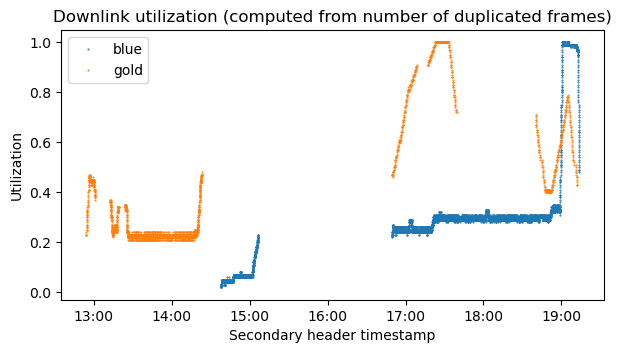

In [11]:
W = 100
for sc in spacecraft:
    plt.plot(timestamps[sc], np.convolve(np.ones(W)/W, ~duplicates[sc], mode='same'), '.', markersize=1, label=sc)
plt.legend()
plt.title('Downlink utilization (computed from number of duplicated frames)')
plt.ylabel('Utilization')
timestamp_axis()

In [12]:
{sc: collections.Counter(a.primary_header.transfer_frame_version_number for a in tm[sc]) for sc in spacecraft}

{'blue': Counter({0: 9154}), 'gold': Counter({0: 4148})}

In [13]:
{sc: collections.Counter(scid[sc]) for sc in spacecraft}

{'blue': Counter({123: 9154}), 'gold': Counter({86: 4148})}

In [14]:
hex(123), hex(86)

('0x7b', '0x56')

In [15]:
{sc: collections.Counter(vcid[sc]) for sc in spacecraft}

{'blue': Counter({np.int64(2): 9154}), 'gold': Counter({np.int64(2): 4148})}

In [16]:
{sc: collections.Counter(a.primary_header.secondary_header_flag for a in tm[sc]) for sc in spacecraft}

{'blue': Counter({True: 9154}), 'gold': Counter({True: 4148})}

In [17]:
mcfc_unwrap = {sc: np.empty(frames[sc].shape[0], 'int') for sc in spacecraft}
for sc in spacecraft:
    last = 0
    for j in range(frames[sc].shape[0]):
        mcfc_unwrap[sc][j] = (mcfc[sc][j] + (last // 256) * 256
                          if last % 256 <= mcfc[sc][j]
                          else mcfc[sc][j] + (last // 256 + 1) * 256)
        last = mcfc_unwrap[sc][j]

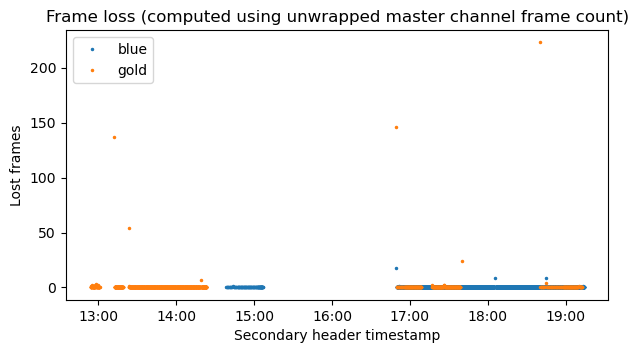

In [18]:
for sc in spacecraft:
    plt.plot(timestamps[sc][~duplicates[sc]][1:], np.diff(mcfc_unwrap[sc][~duplicates[sc]])-1, '.', markersize=3, label=sc)
plt.legend()
plt.title('Frame loss (computed using unwrapped master channel frame count)')
plt.ylabel('Lost frames')
timestamp_axis()

# VC2

Virtual channel 2 contains CCSDS Space Packets. The only APID in use is 51, and the packets in this APID have different sizes, although there are a few sizes that are very frequent. There are ASCII strings from logs in some of the packets.

In [19]:
scid_sc = {'blue': 0x7b, 'gold': 0x56}
packets = {sc: list(ccsds.extract_space_packets([t for t, dup in zip(tm[sc], duplicates[sc]) if not dup], scid_sc[sc], 2))
           for sc in spacecraft}
headers = {sc: [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets[sc]] for sc in spacecraft}

/home/daniel/contracting/ESCAPADE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 123 VC 2] Broken stream. Last frame count 170, current frame count 172
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/ESCAPADE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 123 VC 2] Broken stream. Last frame count 12, current frame count 31
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/contracting/ESCAPADE/ccsds.py:93: UserWarning: [Space Packet extractor Spacecraft 123 VC 2] Broken stream. Last frame count 54, current frame count 56
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new

In [20]:
headers['blue'][:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=251),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=191),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=65),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, pa

In [21]:
headers['gold'][:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=75),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=79),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=99),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=614),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=67),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packet_sequence_count_or_name=0, data_length=267),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=51, sequence_flags=3, packe

In [22]:
{sc: collections.Counter([p.APID for p in headers[sc]]) for sc in spacecraft}

{'blue': Counter({51: 12977}), 'gold': Counter({51: 6297, 52: 1, 16: 1})}

In [23]:
{sc: collections.Counter([p.secondary_header_flag for p in headers[sc]]) for sc in spacecraft}

{'blue': Counter({False: 12977}), 'gold': Counter({False: 6299})}

In [24]:
{sc: collections.Counter([p.data_length for p in headers[sc]]) for sc in spacecraft}

{'blue': Counter({227: 2690,
          75: 1677,
          107: 1673,
          459: 1501,
          24: 836,
          79: 834,
          99: 834,
          91: 814,
          614: 680,
          1093: 521,
          191: 206,
          397: 205,
          63: 135,
          179: 130,
          84: 28,
          94: 25,
          159: 23,
          85: 16,
          74: 14,
          140: 14,
          76: 12,
          120: 9,
          77: 8,
          39: 6,
          51: 4,
          44: 4,
          45: 4,
          93: 4,
          60: 3,
          97: 3,
          46: 3,
          87: 3,
          101: 2,
          49: 2,
          53: 2,
          59: 2,
          89: 2,
          171: 2,
          43: 2,
          251: 1,
          65: 1,
          52: 1,
          50: 1,
          62: 1,
          103: 1,
          131: 1,
          118: 1,
          82: 1,
          58: 1,
          160: 1,
          175: 1,
          83: 1,
          203: 1,
          128: 1,
          92:

In [25]:
def extract_strings(s, minlen=10):
    s0 = b""
    for c in s:
        if c in bytes(string.printable, encoding="ascii"):
            s0 += bytes([c])
        else:
            if len(s0) >= minlen:
                yield str(s0, encoding="ascii")
            s0 = b""
    if len(s0) >= minlen:
        yield str(s0, encoding="ascii")

def shrink_prefix(strings, maxshrink=3):
    for j in range(len(strings)):
        s = strings[j]
        for shrink in range(1, maxshrink + 1):
            if s[shrink:] in strings:
                strings[j] = s[shrink:]

def space_packet_strings(sc):
    strings_in_packets = [
        s for p in packets[sc]
        for s in extract_strings(p[ccsds.SpacePacketPrimaryHeader.sizeof():])
    ]
    shrink_prefix(strings_in_packets)
    return collections.Counter(strings_in_packets)

In [26]:
space_packet_strings('blue')

Counter({'CommsFallback': 1792,
         'ConfigureRadioInternal': 1716,
         'WAIT_UNTIL': 858,
         'DisableComponents': 721,
         'BackorbDownload': 85,
         'FileDownload': 83,
         'BackorbList': 17,
         '\\/mnt/mmc0/logs/compton/inv_sts/inv_sts-1763132730.mtc.gz': 12,
         '^/mnt/mmc0/logs/compton/inv_sts/inv_sts-1763132730.mtc.gz': 10,
         '[/mnt/mmc0/logs/compton/inv_sts/inv_sts-1763132730.mtc.gz': 9,
         'Z/mnt/mmc0/logs/compton/inv_sts/inv_sts-1763132730.mtc.gz': 8,
         'E_CMD_HIST: [ OK  ] CDH_NOOP': 6,
         'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_OCP_EN ENABLE_STATE=[0, Off]': 6,
         'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[109] STATE=[0, E_Low]': 6,
         'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_OCP_EN ENABLE_STATE=[1, On]': 6,
         'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[109] STATE=[1, E_High]': 6,
         '/mnt/mmc0/logs/compton/inv_eps/inv_eps-1762763341.mtc.gz': 6,
         '/mnt/mmc0/logs/c

In [27]:
space_packet_strings('gold')

Counter({'CommsFallback': 206,
         'WAIT_UNTIL': 203,
         'ConfigureRadioInternal': 202,
         'E_INFO: SetThermostatMode: Begin sequence': 39,
         'E_INFO: SetThermostatMode: End sequence': 39,
         'E_INFO: SetThermostatMode: Setting CLOSEDLOOP': 33,
         '-BbL>@)H^D': 9,
         'DisableComponents': 7,
         'E_INFO: DisableComponents: Begin sequence': 6,
         'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_OCP_EN ENABLE_STATE=[0, Off]': 6,
         'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[109] STATE=[0, E_Low]': 6,
         'E_CMD_HIST: [ OK  ] EPS_SPOC_DIO_ST_OCP_EN ENABLE_STATE=[1, On]': 6,
         'E_CMD_HIST: [ OK  ] CDH_SPOC_IO_GPIO_STATE_SET IDX=[109] STATE=[1, E_High]': 6,
         'E_INFO: DisableComponents: End sequence': 6,
         'E_INFO: DisableComponents: ENDPROC': 6,
         '-Bh/.@)H^D': 6,
         'E_INFO: SetThermostatSetpointsClosedLoop: Begin sequence': 6,
         'E_INFO: SetThermostatSetpointsClosedLoop: End sequence': 6